# Simulation of Pt Growth in Sinusoidal Light Regime

## From data in Jallet et. al. 2016 (http://dx.doi.org/10.1016/j.algal.2016.05.014)


#### Initial conditions and parameters:

- Culture volume: 500 mL (cm3)
- Culture height: 23 cm
- Sinusodal light regime: Io(t)= Amax * sine(2 * pi * f * t) where t = seconds after dawn, Amax = 2000 umol m-2 s-1, f = 1.16e-5 s-1
- initial mass = 10.23
    - Calculated from taking TOC and the biomass equation from the model at T=0
    - Calculated a ratio of carbon mass per total mass 
    - Carbon for biomass components came from the model biomass objective function 
- a* was determined using a Pt culture acclimated to 876 umol photons m-2 s-1
- O2 evolution equation in units of nmol O2 ug Chla-1 h-1
- Dark respiration rate: 60 nmol O2 (ug chla h)-1 

Jared Broddrick - 08/24/2018

### Dependencies
Cobrapy

Pandas

csv

xlrd

matplotlib

In [1]:
import pandas as pd
import numpy as np
import csv
import cobra
import xlrd
import re
import math as m
from cobra.core.metabolite import elements_and_molecular_weights
elements_and_molecular_weights['R']=0.0
elements_and_molecular_weights['Z']=0.0
import copy

### 1) Load in the model

In [2]:
# Load in the model
model = cobra.io.load_json_model('Model_iLB1034.json')

### 2) Constrain the media components
##### Media: F/2 ASW



In [5]:
# Load the media composition

EXrxn = ['EX_co2_e','EX_hco3_e','EX_no2_e','EX_no3_e','EX_nh4_e','EX_biotin_e','EX_fe2_e','EX_h_e','EX_h2o_e','EX_o2_e','EX_pi_e','EX_na1_e','EX_so4_e','EX_hso3_e','EX_mg2_e','EX_glyclt_e','EX_selt_e','EX_glc_e','EX_cl_e','EX_thm_e','EX_h2_e','EX_fol_e','EX_co_e','EX_cyan_e','EX_cynt_e','EX_tcynt_e','EX_lac_d_e','EX_etoh_e']
EXub = [1000,1000,0,0,1000,0,1000,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
EXlb = [0,-1000,0,-1000,0,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,0,-1000,0,0,0,-1000,-1000,0,0,0,0,0,0,0,0]
for i in range(len(EXrxn)):
    rx = EXrxn[i]
    model.reactions.get_by_id(rx).lower_bound = EXlb[i]
    model.reactions.get_by_id(rx).upper_bound = EXub[i]

In [3]:
model.reactions.EX_o2_e.upper_bound = 30.   #Allow O2 uptake
model.reactions.EX_o2_e.lower_bound = -100.

model.reactions.DM_biomass_c_acc_c.upper_bound = 60
model.reactions.DM_biomass_c_acc_c.lower_bound = 0

### 3) Change the pigment composition in the model to match T=0 in vivo values


In [6]:
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ---------------------
photon_e  137        o2_e  11.9    bof_dark_c  -4.76e-17
co2_e       7.91                   bof_c        0.17
h2o_e       5.07
h_e         1.8
no3_e       1.76
pi_e        0.22
so4_e       0.0297
mg2_e       0.00435


In [7]:
model.objective = 'bof_c_accumulation_c'
solution = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)
solution.x_dict

In [6]:
pigment_mass = {'caro_h':0.0120,
               'cholphya_h':0.2838,
               'cholphyc1_h':0.0121,
               'cholphyc2_h':0.0269,
               'diadinx_h':0.0572,
               'diatox_h':0.0031,
               'fxanth_h':0.1257}
pigment_data = dict()

for pigm,mass in pigment_mass.iteritems():
    met_obj = model.metabolites.get_by_id(pigm)
    met_stoich = mass/met_obj.formula_weight
    pigment_data[met_obj]=met_stoich*-1*1000.
    
r = model.reactions.biomass_pigm_h

new_stoich = pigment_data

# you now have a dictionary of new stoichs for your model
for m,s in r.metabolites.iteritems():
    stoich = s*-1
    temp_dict = {m:stoich}
    r.add_metabolites(temp_dict)
r.add_metabolites(new_stoich)

# Then get the total to equal 1 mg biomass DW
total = 0
for m,s in r.metabolites.iteritems():
    gfw = model.metabolites.get_by_id(m.id).formula_weight
    mass = gfw*s*-1
    total = total+mass
correction = total/1000 # this will get it to 1000 ug total mass

# Then adjust the stoichiometry as appropriate
for m,s in r.metabolites.iteritems(): # now change the stoich
    to_add = s/correction-s
    r.add_metabolites({m:to_add})

# Finally build the biomass_c metabolite
    imbal = r.check_mass_balance()
    if 'charge' in imbal.keys():
        met_charge = imbal['charge']*-1
        del imbal['charge']
    met_mass = 0
    formula_string = ''
    for e,v in imbal.iteritems():
        if v > 1e-10 or v < -1e-10:
            mass = elements_and_molecular_weights[e]
            met_mass = met_mass+(mass*-1*v)
            form_str = e+str(-1*v)
            formula_string = formula_string + form_str

met = model.metabolites.biomass_pigm_h
met.formula = formula_string
met.charge = met_charge
r.add_metabolites({met:1})

model.repair()

### 4) Global Constraints

#### Reactions to turn off:

rxns = ['DIADINXDE_h','VIOXANDE_h','ANTHXANDE_h']  

These cause loops in the model

#### Output:

Constrained model

In [7]:
# Initial constraints 

# Turn off reactions that cause biologically unrealistic flux loops

rxn =  ['DIATOXEPOX_h','VIOXANDE_h','ANTHXANDE_h']
for i in range(len(rxn)):
    rx = rxn[i]
    model.reactions.get_by_id(rx).lower_bound = 0
    model.reactions.get_by_id(rx).upper_bound = 0
    

# remove constraints on CEF_h, is calculated in the simulation

model.reactions.CEF_h.lower_bound = 0.0
model.reactions.CEF_h.upper_bound = 1000

# Changing the bounds to umol instead of mmol

for r in model.reactions:
    r.lower_bound = r.lower_bound*10.
    r.upper_bound = r.upper_bound*10.

### 5) Photon constraints

First, the oabxc at all wavelengths will be multiplied by the relative spectral distribution

Then, this will be integrated over the photosynthetic range to give a*rel

Light absorbed is equal to a*rel x Io for each irradiance - Which will be done in the simulation loop

#### Calculations to be performed:

Eo = mgChla/gDW x Io x [integral(400-700) relArea x oabxc x dlambda]

This section is taking the integral portion and making a constant

Calculation in the loop:

Eo = mgChla/gDW x Io x auc


#### Output paramaters in this section:

auc in units of m2/mgChla


In [8]:
# Photon constraints

# 1) Photon absorption coefficient 'auc' where:

# Absorbed photons (Eo) = mgChla/gDW x Irradiance x auc
# This output will be the biomass normalized photon absorption rate

# read in the a* values
a_star = pd.read_csv('PBR_optical_abs_xsec.csv',index_col=0,header=0)
a_star = a_star['876']
# read in the PBR lamp spectral density
rel = pd.read_excel('PBR_LED_rel_area.xlsx',header=0)


### 5) Define simulation parameters

#### Time interval: 20 min

#### Number of slices for the vertical light attenuation: 50

#### Initial dry weight of 500 mL vessel = 10.23 mg DW

#### Culture dimensions: 23 cm height, 500 cm3 (mL) total volume, so ~2.6 cm

#### Surface area = 22 cm2

#### Maintenance energy = 60 nmol O2 (mg Chla h)-1

### Update the model biomass objective function to the values in Jallet et. al. 2016

In [9]:
bof_ratios = {'biomass_carb_c':0.063,
               'biomass_dna_c':0.004,
               'biomass_mem_lipids_c':0.034,
               'biomass_pigm_h':0.033,
               'biomass_plastid_lip_h':0.061,
               'biomass_pro_c':0.767,
               'biomass_rna_c':0.030}
bof_data = dict()

for bofcmp,percent in bof_ratios.iteritems():
    met_obj = model.metabolites.get_by_id(bofcmp)
    bof_data[met_obj]=percent*-1

# copy the bof and change to carbon storage
r = model.reactions.bof_c
new_stoich = bof_data

# you now have a dictionary of new stoichs for your model
for m,s in r.metabolites.iteritems():
    stoich = s*-1
    temp_dict = {m:stoich}
    r.add_metabolites(temp_dict)
r.add_metabolites(new_stoich)

# Then get the total to equal 1 mg biomass DW
total = 0
for m,s in r.metabolites.iteritems():
    gfw = model.metabolites.get_by_id(m.id).formula_weight
    mass = gfw*s*-1
    total = total+mass
correction = total/1000 # this will get it to 1000 ug total mass

# Then adjust the stoichiometry as appropriate
for m,s in r.metabolites.iteritems(): # now change the stoich
    to_add = s/correction-s
    r.add_metabolites({m:to_add})

# Finally build the biomass_c metabolite
imbal = r.check_mass_balance()
if 'charge' in imbal.keys():
    met_charge = imbal['charge']*-1
    del imbal['charge']
met_mass = 0
formula_string = ''
for e,v in imbal.iteritems():
    if v > 1e-12 or v < -1e-12:
        mass = elements_and_molecular_weights[e]
        met_mass = met_mass+(mass*-1*v)
        form_str = e+str(-1*v)
        formula_string = formula_string + form_str

# make a new biomass metabolite
met = model.metabolites.biomass_c
met.formula = formula_string
met.charge = met_charge
r.add_metabolites({met:1})

# Add GAM constraint
gam_met = model.metabolites.GAM_const_c
r.add_metabolites({gam_met:1})

model.repair()

cobra\core\metabolite.py:103 UserWarning: 29.6555544631 is not an integer (in formula C29.6555544631H33.538452101O21.8521611469N11.6868909228P3.12183730148)
cobra\core\metabolite.py:103 UserWarning: 33.538452101 is not an integer (in formula C29.6555544631H33.538452101O21.8521611469N11.6868909228P3.12183730148)
cobra\core\metabolite.py:103 UserWarning: 21.8521611469 is not an integer (in formula C29.6555544631H33.538452101O21.8521611469N11.6868909228P3.12183730148)
cobra\core\metabolite.py:103 UserWarning: 11.6868909228 is not an integer (in formula C29.6555544631H33.538452101O21.8521611469N11.6868909228P3.12183730148)
cobra\core\metabolite.py:103 UserWarning: 3.12183730148 is not an integer (in formula C29.6555544631H33.538452101O21.8521611469N11.6868909228P3.12183730148)
cobra\core\metabolite.py:103 UserWarning: 36.9937318057 is not an integer (in formula C36.9937318057H59.5828582832O30.7256809086S0.125712773874)
cobra\core\metabolite.py:103 UserWarning: 59.5828582832 is not an integ

### Update the dark period biomass objective function

#### Doesn't include pigments since the current literature claims chlorophyll biosynthesis in Pt is light dependent (see main text)

In [10]:
r = model.reactions.bof_dark_c
new_stoich = bof_data

met_pigm = model.metabolites.biomass_pigm_h

del new_stoich[met_pigm]

# you now have a dictionary of new stoichs for your model
for m,s in r.metabolites.iteritems():
    stoich = s*-1
    temp_dict = {m:stoich}
    r.add_metabolites(temp_dict)
r.add_metabolites(new_stoich)

# Then get the total to equal 1 mg biomass DW
total = 0
for m,s in r.metabolites.iteritems():
    gfw = model.metabolites.get_by_id(m.id).formula_weight
    mass = gfw*s*-1
    total = total+mass
correction = total/1000 # this will get it to 1000 ug total mass

# Then adjust the stoichiometry as appropriate
for m,s in r.metabolites.iteritems(): # now change the stoich
    to_add = s/correction-s
    r.add_metabolites({m:to_add})

# Finally build the biomass_c metabolite
imbal = r.check_mass_balance()
if 'charge' in imbal.keys():
    met_charge = imbal['charge']*-1
    del imbal['charge']
met_mass = 0
formula_string = ''
for e,v in imbal.iteritems():
    if v > 1e-12 or v < -1e-12:
        mass = elements_and_molecular_weights[e]
        met_mass = met_mass+(mass*-1*v)
        form_str = e+str(-1*v)
        formula_string = formula_string + form_str

# make a new biomass metabolite
met = model.metabolites.biomass_dark_c
met.formula = formula_string
met.charge = met_charge
r.add_metabolites({met:1})

# Add GAM constraint
gam_met = model.metabolites.GAM_const_c
r.add_metabolites({gam_met:1})

model.repair()

In [11]:
# Initialize all initial conditions, output variables and storage pools
iDW = 10.5 # initial culture biomass minus storage carbon
xsec = 22. #culture cross sectional area in cm2

model.reactions.ATPM_c.upper_bound = 0.
model.reactions.ATPM_c.lower_bound = 0.
model.reactions.ATPM_h.upper_bound = 0.
model.reactions.ATPM_h.lower_bound = 0.
model.reactions.ATPM_m.upper_bound = 0.
model.reactions.ATPM_m.lower_bound = 0.

# NGAM is set by using the AOX reaction lower bound to a positive non-zero value

slices = 50  # number of slices
vol = 100./slices      # percent volume of each vertical slice
rv = vol/100. # fractional volume of each slice


# make a dict or dataframe that holds the initial mgDW of each biomass component
# This will be updated at each simulation point and compared to the data from Jallet et al.
# Pull ratios out of the BOF and multiply them by the total inital mass

rxn = model.reactions.bof_c
data_dict = dict()
for met,s in rxn.metabolites.iteritems():
    if s<0:
        data_dict[met.id]=-1*s*iDW #Takes the intial biomass and calculates the mgDW for each component
data_dict[model.metabolites.carbon_storage_c.id]=0.006*iDW    
data_dict['total']=sum(data_dict.values())
biomass = pd.DataFrame(data=data_dict.values(),index = data_dict.keys(),columns=['0'])


In [12]:
biomass

,0
biomass_dna_c,0.042339
biomass_carb_c,0.666835
biomass_plastid_lip_h,0.645665
biomass_mem_lipids_c,0.359879
biomass_pro_c,8.118448
biomass_pigm_h,0.349294
carbon_storage_c,0.063000
biomass_rna_c,0.317540
total,10.563000


In [13]:
# Energetic coupling as in Ballieu 2015 Nature paper

from cobra import Metabolite
m1 = Metabolite(
    'mito_coupling_const_h',
    formula='',
    name='Mito-Plastid Energetic Coupling Constraint',
    compartment='h')

m1._constraint_sense = 'G'


reaction = model.reactions.PSI_u
reaction.add_metabolites({m1:-0.15})

reaction = model.reactions.NADHOR_m
reaction.add_metabolites({m1:1.})

# Non-photochemical loss of photons
reaction = model.reactions.DM_biomass_c.copy()
reaction.id = 'DM_photon_c'
reaction.name = 'Demand Reaction: Photon'
m1 = model.metabolites.biomass_c
m2 = model.metabolites.photon_c

reaction.add_metabolites({m1:1,
                         m2:-1})

model.add_reaction(reaction)
model.repair()

# Set AEF to Ballieu 2015 Nature paper

model.reactions.PTOX_h.upper_bound = 0.
model.reactions.MEHLER_h.upper_bound = 0.

# Carbon storage mobilization sinks
reaction = model.reactions.DM_biomass_c.copy()
reaction.id = 'DM_13glucan_c'
reaction.name = 'Demand Reaction: Stored carbohydrates'
m1 = model.metabolites.biomass_c
m2 = model.metabolites.get_by_id('13glucan_c')

reaction.add_metabolites({m1:1,
                         m2:1})

reaction.lower_bound = 0.
reaction.upper_bound = 0.
model.add_reaction(reaction)

reaction = model.reactions.DM_biomass_c.copy()
reaction.id = 'DM_tag1619Z1619Z160_c'
reaction.name = 'Demand Reaction: Stored triacylglycerides'
m1 = model.metabolites.biomass_c
m2 = model.metabolites.tag1619Z1619Z160_c

reaction.add_metabolites({m1:1,
                         m2:1})

reaction.lower_bound = 0.
reaction.upper_bound = 0.
model.add_reaction(reaction)
model.repair()

#Temp demand reaction to allow excess photons to leave the system
reaction = model.reactions.DM_biomass_c.copy()
reaction.id = 'DM_pigm'
reaction.name = 'Demand Reaction: Pigm'
m1 = model.metabolites.biomass_c
m2 = model.metabolites.biomass_pigm_h

reaction.add_metabolites({m1:1,
                         m2:-1})

reaction.reaction
model.add_reaction(reaction)
model.repair()

model.reactions.DM_biomass_c_acc_c.upper_bound = 1000000
model.reactions.DM_biomass_c_acc_c.lower_bound = 0
# model.reactions.DM_pigm.upper_bound = 0
# model.reactions.DM_pigm.lower_bound = 0

In [14]:
# Load in the biomass partioning in % mass
time_bof = pd.read_excel('percent_bof.xlsx')

In [15]:
# flux only constraints, cause an unrealistic loop in a cofactor metabolic pathway
model.reactions.PDYXPT_c.upper_bound = 0.
model.reactions.PDYXPT_c.lower_bound = 0.
model.reactions.PYDXDH_c.upper_bound = 0.
model.reactions.PYDXDH_c.lower_bound = 0.

# Collect fluxes if desired 
get_fluxes = 360

In [16]:
## Initialize all the parameters and variables for the simulation

# Simulate biomass accumulation

import math as m

time_interval = 20 # time between simulations in minutes

iDW = biomass['0']['total']

gDW = iDW

##________________________Initialize carbon tracking for stage transitions____________________________________________
# initial_carbon 
# equal to the inital dry weight coupled with the current ratio of biomass components

initial_carbon = 0
biomass_dict = biomass['0'].to_dict()
for bm,val in biomass_dict.iteritems():
    if bm in model.metabolites:
        met = model.metabolites.get_by_id(bm)
        carbon_mol = met.elements['C']
        carbon_mass = carbon_mol*elements_and_molecular_weights['C']
        initial_carbon = initial_carbon + carbon_mass*val/1000
TOC_counter = dict()
TOC_counter[0]=initial_carbon

stage = 1 #Objective function stage 1: carbon accumulation, 2: balance to T=0 ratios 3: optional additional growth

model.reactions.bof_c.upper_bound = 0.
model.reactions.bof_cell_division_c.upper_bound = 0.
model.reactions.bof_dark_c.upper_bound = 0.

#___________________________________________________Initialize variables to collect output data___________________________________
# Initialize an unused photon count
photon_usage = pd.DataFrame(data=[0,0],index = ['Delivered','Absorbed'],columns=['0'])

# Initialize the carbon storage tracker
mgChry = biomass['0']['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.get_by_id('13glucan_c')]*model.metabolites.get_by_id('13glucan_c').formula_weight/1000.*-1
mgTAG = biomass['0']['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.tag1619Z1619Z160_c]*model.metabolites.tag1619Z1619Z160_c.formula_weight/1000.*-1
storage_DF = pd.DataFrame(data=[mgChry,mgTAG],index = ['Chrysolaminarin','TAG'],columns=['0'])

# Initialize an O2 evolution rate tracker
o2_evolution_rate = pd.DataFrame(data=[0],index = ['Max oxygen evolution'],columns=['0'])
co2_uptake_rate = pd.DataFrame(data=[0],index = ['Ci uptake'],columns=['0'])
o2_check = pd.DataFrame(data=[0],index = ['Max oxygen evolution'],columns=['0'])

cobra\core\metabolite.py:103 UserWarning: 80.1193308081 is not an integer (in formula H80.1193308081C44.2630563716O21.6916965507P1.30949873186)
cobra\core\metabolite.py:103 UserWarning: 44.2630563716 is not an integer (in formula H80.1193308081C44.2630563716O21.6916965507P1.30949873186)
cobra\core\metabolite.py:103 UserWarning: 21.6916965507 is not an integer (in formula H80.1193308081C44.2630563716O21.6916965507P1.30949873186)
cobra\core\metabolite.py:103 UserWarning: 1.30949873186 is not an integer (in formula H80.1193308081C44.2630563716O21.6916965507P1.30949873186)


In [17]:
# Simulate over the time interval

for t in range(time_interval,1440+time_interval,time_interval): #One simulation every 20 minutes from t=0 to t=24 hrs (1440 min)
    
    if t<(720+time_interval):
        stage = 1
        # First, build the biomass equation for this time point
        # build bof_data dict
        bof_data = time_bof[t].to_dict()
        reaction = model.reactions.bof_c_accumulation_c
        for m,s in reaction.metabolites.iteritems():
            stoich = s*-1
            temp_dict = {m:stoich}
            reaction.add_metabolites(temp_dict)

        for bm_met,bm_s in bof_data.iteritems():
            met_to_add = model.metabolites.get_by_id(bm_met)
            reaction.add_metabolites({met_to_add:bm_s})

        # Then get the total to equal 1 mg biomass DW
        total = 0
        for m,s in reaction.metabolites.iteritems():
            gfw = model.metabolites.get_by_id(m.id).formula_weight
            mass = gfw*s*-1
            total = total+mass
        correction = total/1000 # this will get it to 1 mg total mass

        # Then adjust the stoichiometry as appropriate
        for m,s in reaction.metabolites.iteritems(): # now change the stoich
            to_add = s/correction-s
            reaction.add_metabolites({m:to_add})
        # Finally build the biomass_c metabolite
        imbal = reaction.check_mass_balance()
        met_charge = imbal['charge']*-1
        del imbal['charge']
        met_mass = 0
        formula_string = ''
        for e,v in imbal.iteritems():
            mass = elements_and_molecular_weights[e]
            met_mass = met_mass+(mass*-1*v)
            form_str = e+str(-1*v)
            formula_string = formula_string + form_str

        met = model.metabolites.biomass_c_acc_c
        met.formula = formula_string
        met.charge = met_charge
        reaction.add_metabolites({met:1})

        # Add GAM constraint
        gam_met = model.metabolites.GAM_const_c
        reaction.add_metabolites({gam_met:1})
        
        model.repair()
            
        ## _____________________________Light related constraints_________________________________________##
        import math as m
        
        tmp_data = dict(zip(data_dict.keys(),[0,0,0,0,0,0,0,0,0])) #Initialize the biomass accumulator
        del tmp_data['total']
        interval_bm = 0 #initializes the total biomass
        photon_count = 0
        atten = np.zeros(len(a_star)) #captures light attenuation
        
        tmp_o2_evo = 0
        
        gDW = biomass[str(t-time_interval)]['total']
        
        chla_stoich = model.reactions.biomass_pigm_h.metabolites[model.metabolites.cholphya_h]# umol Chla per mg pigments
        chla = chla_stoich*model.metabolites.cholphya_h.formula_weight*-0.001# converts to mg Chla per mg pigments
        mgchla = chla *(biomass[str(t-time_interval)]['biomass_pigm_h'])# mg Chla

        #O2 rate equation Returns the parameters to get the O2 rate per umol photons absorbed/mgChla*s
        alpha = 147.3
        beta = -2.86
        Ps = ((-6.0869e-4)*m.pow((t-(time_interval/2.)),2))+(4.3142e-1*(t-(time_interval/2.)))+296.2
        irrad = 2000.*(m.sin(2.*m.pi*(1.1574074074074e-5)*(t-(time_interval/2.))*60.)) 
        # incident light equation from the publication set to the middle of the time interval
        # in umol photons/m2*s
        
        photon_flux = (rel['rel_area'].values)*irrad*xsec/10000*time_interval*60.
        total_photons = sum(photon_flux)
        photon_usage[str(t)]=[total_photons,0]
    
        # For each slice:
        #     - Walk through the spectrum calculating absorbed photons and updating the initial value (delivered)
        #     - At the end of the slice sum the totals to get photons absorbed
        #     - Update a running tally of photons absorbed
        total_absorbed = 0.
        
        corr_a_star = a_star*1.2
        
        ti_o2 = 0.
        
        for s in range(slices):
            
            # First get delivered photons
            delivered_photons = photon_flux

            # Variable to collect the photons absorbed
            slice_abs = 0.
            slice_o2 = 0. 
            for nm in range(len(photon_flux)):
                # calculate the absorbed photons
                abs_coeff = corr_a_star[400+nm]                              # a* value for the given nm (m2/mgchla)
                nm_delivered = delivered_photons[nm]                    # incident photon flux at this nm at this slice (umol_photon/time_interval)
                nm_abs = nm_delivered*abs_coeff*(mgchla*rv)/xsec*10000. # photons absorbed at this nm at this slice(umol/TI * m2/mgchla * mgchla * 1/cm2 * 10000cm2/m2)

                # Update the photon_flux variable at this wavelength
                new_delivered = nm_delivered - nm_abs
                if new_delivered >= 0:
                   photon_flux[nm] = new_delivered
                else:
                   photon_flux[nm] = 0.

                # Append the running photon absorption
                slice_abs = slice_abs + nm_abs
                
            # Update the variables that will constrain photon flux
            total_absorbed = total_absorbed+slice_abs
            conv_abs = slice_abs/20./60./(mgchla*rv) # converts abs to O2 evo curve units  umol/TI * TI/min * min/s * 1/mgchla => umol/(mgchla*s)
            slice_o2 = Ps*(1-m.exp(-1*alpha*conv_abs/Ps))*(m.exp(-1*beta*conv_abs/Ps)) #O2 evolution umolO2/(mgChla*h) 
            
            ti_o2 = ti_o2+(slice_o2*(rv*mgchla)/60.*time_interval)
            
        o2_check[str(t)]=ti_o2
        abs_units = total_absorbed/20./60./(mgchla) # converts abs to O2 evo curve units  umol/TI * TI/min * min/s * 1/mgchla => umol/(mgchla*s)    
        o2evo = ti_o2
        model.reactions.EX_o2_e.upper_bound = o2evo

        cef_rate = 5.*gDW/60.*time_interval #CEF sets CEF_h upper bound.  umol /(mgDW*h) * mgDW * h/60min * min/TI = umol/TI
        model.reactions.CEF_h.upper_bound = cef_rate
    
                
        # ________________________________Slice specific constraints_________________________________________#

        ngam = 60.*mgchla/60.*time_interval #NGAM sets AOX_m lower bound. 60 umol O2/(mgCha*h) * mgChla/mgDW * mgDW * h/60min  -> umol O2
        model.reactions.AOX_m.lower_bound = ngam
  
        #Photon constraints
        model.reactions.EX_photon_e.lower_bound = total_absorbed*-1.
        model.reactions.EX_photon_e.upper_bound = total_absorbed*-0.9999
        
        
                
       ###__________________________________OBJECTIVE FUNCTION____________________________________###

        ##__________________________________Stage 1 Light_________________________________
        model.objective = 'bof_c_accumulation_c'
        solution = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)
        if solution.status == 'optimal':
            obj_rxn = model.reactions.bof_c_accumulation_c

            for bm,val in tmp_data.iteritems():
                bm_flux = obj_rxn.x

                if bm in model.metabolites and model.metabolites.get_by_id(bm) in obj_rxn.metabolites.keys():
                    stoich = obj_rxn.metabolites[model.metabolites.get_by_id(bm)]
                    tmp_flux = stoich*bm_flux*-1.
                    total_flux = val+tmp_flux
                    tmp_data[bm]=total_flux

                else:
                    tmp_data[bm]=0.

            interval_bm = sum(tmp_data.values())

        else: 
            interval_bm = interval_bm + 0.
                
        tmp_data['total']=interval_bm
        interval_totals = biomass[str(t-(time_interval))]+tmp_data.values()
        
        biomass[str(t)]= interval_totals
        
        mgChry = biomass[str(t)]['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.get_by_id('13glucan_c')]*model.metabolites.get_by_id('13glucan_c').formula_weight/1000.*-1
        mgTAG = biomass[str(t)]['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.tag1619Z1619Z160_c]*model.metabolites.tag1619Z1619Z160_c.formula_weight/1000.*-1
        storage_DF[str(t)]= [mgChry,mgTAG]
        
        interval_TOC = 0
        carbon_count = biomass[str(t)].to_dict()
        for bm,val in carbon_count.iteritems():
            if bm in model.metabolites:
                met = model.metabolites.get_by_id(bm)
                carbon_mol = met.elements['C']
                carbon_mass = carbon_mol*elements_and_molecular_weights['C']
                interval_TOC = interval_TOC + carbon_mass*val/1000
           
        TOC_counter[t]=interval_TOC
        o2_evolution_rate[str(t)]=tmp_o2_evo
        
         
        photon_usage[str(t)]['Absorbed']=total_absorbed
   
    ##_______________________________________________Dark period simulation_______________________________________##
    else:
        ##____________________________________________generic constraints_____________________________________##
        
        if t == (720+time_interval):
            stage = 2
            total_tag_rate = 0.
            total_carb_rate = 0.
        irrad = 0
        model.reactions.EX_o2_e.upper_bound = 10000.   #Allow O2 uptake
        model.reactions.EX_o2_e.lower_bound = -10000.
        model.reactions.EX_photon_e.lower_bound = 0      # Turn off the lights
        model.reactions.EX_photon_e.upper_bound = 0
        model.reactions.DM_carbon_storage_c.upper_bound = 0 
        model.reactions.DM_carbon_storage_c.lower_bound = 0
        model.reactions.RUBISC_h.upper_bound = 0          # Light dependent RUBISCO inhibition
        model.reactions.RUBISO_h.upper_bound = 0
        model.reactions.DM_biomass_c_acc_c.upper_bound = 0  
        model.reactions.DM_biomass_c_acc_c.lower_bound = 0
        model.reactions.TPTPti_h.lower_bound = -10000. # Allow triose phosphates to be transported into chloroplast at night
#         model.reactions.DM_pigm.upper_bound = 0          # Pigment biosynthesis is light dependent
#         model.reactions.DM_pigm.lower_bound = 0
        
        #NGAM
        chla_stoich = model.reactions.biomass_pigm_h.metabolites[model.metabolites.cholphya_h]# umol Chla per mg pigments
        chla = chla_stoich*model.metabolites.cholphya_h.formula_weight*-0.001# converts to mg Chla per mg pigments
        mgchla = chla *(biomass[str(t-time_interval)]['biomass_pigm_h'])# mg Chla
        ngam = 35.*mgchla/60.*time_interval #NGAM sets AOX_m lower bound. umol O2/(mgCha*h) * mgChla/mgDW * mgDW * h/60min  -> umol O2
        model.reactions.AOX_m.lower_bound = ngam
        
        model.reactions.bof_cell_division_c.upper_bound = 10000.
        tmp_data = dict(zip(data_dict.keys(),[0,0,0,0,0,0,0,0,0])) #Initialize the biomass accumulator
        del tmp_data['total']
        interval_bm = 0 #initializes the total biomass
        
      
        # Stage 2 is to get all the component ratio back to T=0 levels

        # 1) parse biomass DF
        fold_change = [l/f for l,f in zip(biomass['720'].values,biomass['0'].values)]

        # 2) get fold increase for everything
        fold_dict = dict(zip(biomass.index,fold_change))
        target_fold = np.mean([fold_dict['biomass_pigm_h'],fold_dict['biomass_plastid_lip_h']])
        # 3) Determine the delta remaining
        target_mass = [m*target_fold for m in biomass['0'].values]
        target_dict = dict(zip(biomass.index,target_mass))
        del target_dict['total']
        del target_dict['carbon_storage_c']
        del target_dict['biomass_plastid_lip_h']
        del target_dict['biomass_pigm_h']

        delta_dict = dict()
        for bm,target in target_dict.iteritems():
            current_mass = biomass[str(t-time_interval)][bm]
            delta = target_dict[bm]-current_mass
            if delta >0:
                delta_dict[bm]=delta
                
            else:
                delta_dict[bm]=0
            
        # Check for achieving equal fold change across the biomass components
        if stage == 2:
            remaining_bm = dict()
            current_biomass_values = biomass[str(t-time_interval)]
            stage_transition_flag = dict()
            for bm_comps,numbers in target_dict.iteritems():
                delta_mass = numbers-current_biomass_values[bm_comps]
                remaining_bm[bm_comps] = delta_mass
                if delta_mass <0 or delta_mass < 0.05*numbers:
                    stage_transition_flag[bm_comps]=0
                else:
                    stage_transition_flag[bm_comps]=1
            if sum(stage_transition_flag.values()) == 0:
                stage = 3
                message = (t,'Stage 3 triggered')
                print message
                model.reactions.DM_biomass_dark_c.upper_bound = 10000.
                model.reactions.bof_dark_c.upper_bound = 10000.
                model.reactions.bof_cell_division_c.upper_bound = 0
            

        # 4) convert that delta to a cell_div biomass objective function
        if stage == 2:
            total_delta = sum(delta_dict.values())
            bof_data = dict()
            for bm,delta in delta_dict.iteritems():
                percent_mass = delta/total_delta
                bof_data[bm]=percent_mass

            reaction = model.reactions.bof_cell_division_c
            for m,s in reaction.metabolites.iteritems():
                stoich = s*-1
                temp_dict = {m:stoich}
                reaction.add_metabolites(temp_dict)

            for bm_met,bm_s in bof_data.iteritems():
                met_to_add = model.metabolites.get_by_id(bm_met)
                reaction.add_metabolites({met_to_add:bm_s})
                
            total = 0 # Then get the total to equal 1000 mg biomass DW

            for m,s in reaction.metabolites.iteritems():
                gfw = model.metabolites.get_by_id(m.id).formula_weight
                mass = gfw*s*-1
                total = total+mass
            correction = total/1000 # this will get it to 1000 ug total mass

            # Then adjust the stoichiometry as appropriate
            for m,s in reaction.metabolites.iteritems(): # now change the stoich
                to_add = s/correction-s
                reaction.add_metabolites({m:to_add})

            # Finally build the biomass_c metabolite
            imbal = reaction.check_mass_balance()
            met_charge = imbal['charge']*-1
            del imbal['charge']
            met_mass = 0
            formula_string = ''
            for e,v in imbal.iteritems():
                if v > 1e-10 or v < -1e-10:
                    mass = elements_and_molecular_weights[e]
                    met_mass = met_mass+(mass*-1*v)
                    form_str = e+str(-1*v)
                    formula_string = formula_string + form_str

            met = model.metabolites.biomass_cell_div_c
            met.formula = formula_string
            met.charge = met_charge
            reaction.add_metabolites({met:1})

            # Add GAM constraint
            gam_met = model.metabolites.GAM_const_c
            reaction.add_metabolites({gam_met:1})
            
            model.repair()
            
            
            # 5) mobilize carbon(99% of total, linear decrease)
            
            tags = model.metabolites.tag1619Z1619Z160_c
            carbs = model.metabolites.get_by_id('13glucan_c')

            initial_tag = storage_DF['720']['TAG']
            initial_carb = storage_DF['720']['Chrysolaminarin']

            avail_tag = 0.99*initial_tag/tags.formula_weight*1000.
            avail_carb = 0.99*initial_carb/carbs.formula_weight*1000.

            mg_tag = storage_DF[str(t-time_interval)]['TAG']
            mg_carbs = storage_DF[str(t-time_interval)]['Chrysolaminarin']

            if mg_tag >0:
                tag_nu = (avail_tag/720.)*time_interval
                
                rate_tag = tag_nu

            else:
                rate_tag = 0

            if mg_carbs >0:
                carb_nu = (avail_carb/720.)*time_interval

                rate_carb = carb_nu

            else:
                rate_carb = 0

            model.reactions.DM_tag1619Z1619Z160_c.upper_bound = rate_tag
            model.reactions.DM_13glucan_c.upper_bound = rate_carb
            ###
            model.objective='bof_cell_division_c'

            solution = model.optimize()
            if solution.status == 'optimal':
                solution = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)
                obj_rxn = model.reactions.bof_cell_division_c
                for bm,val in tmp_data.iteritems():
                    bm_flux = solution.x_dict[obj_rxn.id]

                    if bm == 'biomass_pigm_h':
                        tmp_data['biomass_pigm_h']=0

                    elif bm == 'carbon_storage_c':
                        umol_tag_used = model.reactions.DM_tag1619Z1619Z160_c.x
                        umol_carbs_used = model.reactions.DM_13glucan_c.x
                        mg_used_tag = umol_tag_used * tags.formula_weight/1000.
                        mg_used_carb = umol_carbs_used * carbs.formula_weight/1000.
                        tmp_data['carbon_storage_c']=val-(mg_used_tag+mg_used_carb)

                    elif bm in model.metabolites and model.metabolites.get_by_id(bm) in obj_rxn.metabolites.keys():
                        stoich = obj_rxn.metabolites[model.metabolites.get_by_id(bm)]
                        tmp_flux = stoich*bm_flux*-1.
                        total_flux = val+tmp_flux
                        tmp_data[bm]=total_flux

                    else:
                        tmp_data[bm]=0.

                interval_bm = sum(tmp_data.values())

                carb_used = model.reactions.DM_13glucan_c.x*model.metabolites.get_by_id('13glucan_c').formula_weight/1000.
                tag_used = model.reactions.DM_tag1619Z1619Z160_c.x*model.metabolites.tag1619Z1619Z160_c.formula_weight/1000.

                mgTAG = mg_tag-tag_used
                mgChry = mg_carbs-carb_used
                storage_DF[str(t)]= [mgChry,mgTAG]

            else: 
                interval_bm = 0
                carb_used = 0
                tag_used = 0
                mgTAG = mg_tag-tag_used
                mgChry = mg_carbs-carb_used
                storage_DF[str(t)]= [mgChry,mgTAG]
        
        
        
        if stage == 3:
            
            tags = model.metabolites.tag1619Z1619Z160_c
            carbs = model.metabolites.get_by_id('13glucan_c')

            initial_tag = storage_DF['720']['TAG']
            initial_carb = storage_DF['720']['Chrysolaminarin']

            avail_tag = 0.99*initial_tag/tags.formula_weight*1000.
            avail_carb = 0.99*initial_carb/carbs.formula_weight*1000.

            mg_tag = storage_DF[str(t-time_interval)]['TAG']
            mg_carbs = storage_DF[str(t-time_interval)]['Chrysolaminarin']

            if mg_tag >0:
                tag_nu = (avail_tag/720.)*time_interval
                
                rate_tag = tag_nu

            else:
                rate_tag = 0

            if mg_carbs >0:
                carb_nu = (avail_carb/720.)*time_interval

                rate_carb = carb_nu

            else:
                rate_carb = 0

            model.reactions.DM_tag1619Z1619Z160_c.upper_bound = rate_tag
            model.reactions.DM_13glucan_c.upper_bound = rate_carb
            ###
            model.objective = 'bof_dark_c'

            solution = model.optimize()
            if solution.status == 'optimal':
                solution = cobra.flux_analysis.parsimonious.optimize_minimal_flux(model)
                obj_rxn = model.reactions.bof_dark_c

                for bm,val in tmp_data.iteritems():
                    bm_flux = solution.x_dict[obj_rxn.id]

                    if bm == 'carbon_storage_c':
                        umol_tag_used = model.reactions.DM_tag1619Z1619Z160_c.x
                        umol_carbs_used = model.reactions.DM_13glucan_c.x
                        mg_used_tag = umol_tag_used * tags.formula_weight/1000.
                        mg_used_carb = umol_carbs_used * carbs.formula_weight/1000.
                        tmp_data['carbon_storage_c']=val-(mg_used_tag+mg_used_carb)

                    elif bm in model.metabolites and model.metabolites.get_by_id(bm) in obj_rxn.metabolites.keys():

                        stoich = obj_rxn.metabolites[model.metabolites.get_by_id(bm)]
                        tmp_flux = stoich*bm_flux*-1.
                        total_flux = val+tmp_flux
                        tmp_data[bm]=total_flux

                    else:
                        tmp_data[bm]=0.
                    
                interval_bm = sum(tmp_data.values())
                
                carb_used = model.reactions.DM_13glucan_c.x*model.metabolites.get_by_id('13glucan_c').formula_weight/1000.
                tag_used = model.reactions.DM_tag1619Z1619Z160_c.x*model.metabolites.tag1619Z1619Z160_c.formula_weight/1000.

                mgTAG = mg_tag-tag_used
                mgChry = mg_carbs-carb_used
                storage_DF[str(t)]= [mgChry,mgTAG]


            else: 
                interval_bm = 0
                carb_used = 0
                tag_used = 0
                mgTAG = mg_tag-tag_used
                mgChry = mg_carbs-carb_used
                storage_DF[str(t)]= [mgChry,mgTAG]
    
        #Collect the data and load it into the Dataframe

        tmp_data['total']=interval_bm
        interval_totals = biomass[str(t-(time_interval))]+tmp_data.values()
        
        biomass[str(t)]= interval_totals
        
        mgChry = biomass[str(t)]['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.get_by_id('13glucan_c')]*model.metabolites.get_by_id('13glucan_c').formula_weight/1000.*-1
        mgTAG = biomass[str(t)]['carbon_storage_c']*model.reactions.biomass_c_storage_c.metabolites[model.metabolites.tag1619Z1619Z160_c]*model.metabolites.tag1619Z1619Z160_c.formula_weight/1000.*-1
        storage_DF[str(t)]= [mgChry,mgTAG]
        
        interval_TOC = 0
        carbon_count = biomass[str(t)].to_dict()
        for bm,val in carbon_count.iteritems():
            if bm in model.metabolites:
                met = model.metabolites.get_by_id(bm)
                carbon_mol = met.elements['C']
                carbon_mass = carbon_mol*elements_and_molecular_weights['C']
                interval_TOC = interval_TOC + carbon_mass*val/1000
           
        TOC_counter[t]=interval_TOC
    ## Get fluxes for appropriate intervals
    if t == get_fluxes:
        flux_val = solution.x_dict


c:\python27\lib\site-packages\ipykernel_launcher.py:192 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(740, 'Stage 3 triggered')


### Plot the results

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
from pylab import *

Text(0.5,1,u'Protein')

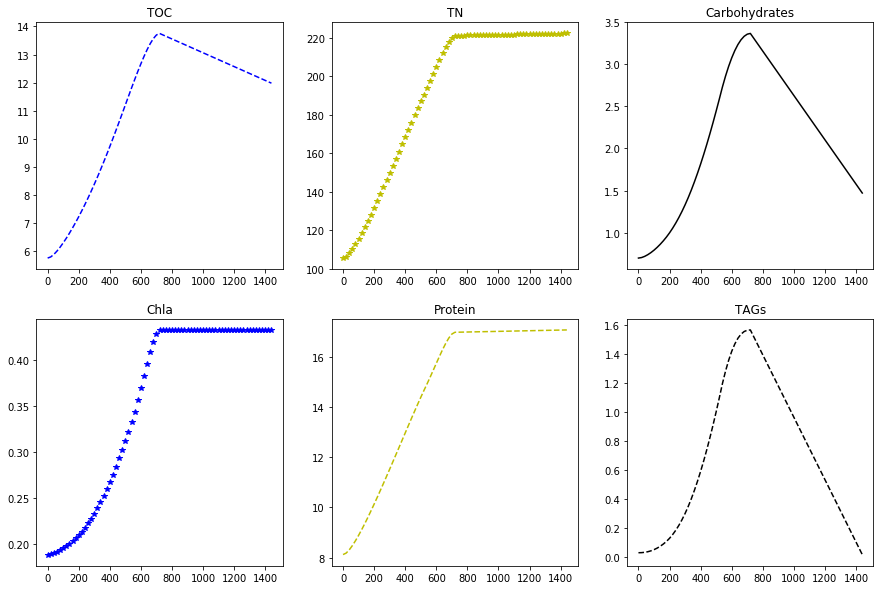

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
x = [int(c) for c in biomass.columns]
## TOC
lists = sorted(TOC_counter.items())
x1,y1 = zip(*lists)

plt.subplot(2,3,1)
plot(x1,y1,'b--')
plt.title('TOC')

## TN
TN_dict = dict()
for t in biomass.keys():
    total_N = 0
    outputs = biomass[t]
    for a,b in outputs.iteritems():
        if a in model.metabolites:
            met = model.metabolites.get_by_id(a)
            if 'N' in met.elements:
                n_mol = met.elements['N']
                total_N = total_N + n_mol*b
    TN_dict[int(t)]=total_N
    
TN_lists = sorted(TN_dict.items())
x2,y2 = zip(*TN_lists)
plt.subplot(2,3,2)
plot(x2,y2,'y*')
plt.title('TN')

## Carbohydrates
storage_carb = list()
for t,v in storage_DF.loc['Chrysolaminarin'].iteritems():
    storage_carb.append((v))
struct_carb = list()
for t,v in biomass.loc['biomass_carb_c'].iteritems():
    struct_carb.append((v))
    
total_carbs = list()
for i in range(len(struct_carb)):
    total_carbs.append(struct_carb[i]+storage_carb[i])

t_pt = [int(c) for c in biomass.columns]
total_carb = zip(t_pt,total_carbs)
x3,y3 = zip(*total_carb)
plt.subplot(2,3,3)
plot(x3,y3,'k')
plt.title('Carbohydrates')

# TAGs
tags = list()
for t,v in storage_DF.loc['TAG'].iteritems():
    tags.append((int(t),v))
x4,y4 = zip(*tags)
plt.subplot(2,3,6)
plot(x4,y4,'k--')
plt.title('TAGs')

# Chlorophyll a
chla_bm = list()
for t,v in biomass.loc['biomass_pigm_h'].iteritems():
    chla_bm.append((v*0.54))
chla_bm = zip(t_pt,chla_bm)
x5,y5 = zip(*chla_bm)
plt.subplot(2,3,4)
plot(x5,y5,'b*')
plt.title('Chla')

# Protein
pro_bm = list()
for t,v in biomass.loc['biomass_pro_c'].iteritems():
    pro_bm.append((v))
pro_bm = zip(t_pt,pro_bm)
x6,y6 = zip(*pro_bm)
plt.subplot(2,3,5)
plot(x6,y6,'y--')
plt.title('Protein')


In [20]:
flux_val.to_csv('sinusoidal_noon_wt.csv')